In [17]:
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE
from sklearn import metrics

from sklearn.metrics import classification_report

from nltk.tokenize import word_tokenize

from sklearn.metrics import accuracy_score

from matplotlib import pylab as plt

In [17]:
def analysis_hist(name):
    """Oh I'm so sorry for that name. The function is for analysing histograms of features"""
    plt.figure(figsize=(10,6))
    plt.hist(data[name], bins=20)
    plt.xlabel('Values')
    plt.ylabel(name)
    plt.show()

### Loading data...

In [6]:
data = pd.read_csv('train.csv')
data.drop('Unnamed: 7', axis=1, inplace=True)  # там какая-то лишняя колонка была

### Анализируем данные

In [8]:
data.head(10)

,Tweet,following,followers,actions,is_retweet,location,Type
0,Good Morning Love @LeeBrown_V,0.0,0.0,0.0,0.0,"Pennsylvania, USA",Quality
1,'@realDonaldTrump @USNavy RIP TO HEROES',42096.0,61060.0,5001.0,0.0,"South Padre Island, Texas",Spam
2,Haven't been following the news but I understa...,0.0,0.0,NaN,0.0,Will never be broke ever again,Quality
3,pic.twitter.com/dy9q4ftLhZ What to do with pap...,0.0,0.0,0.0,0.0,Mundo,Quality
4,#DidYouKnow ► Mahatma Gandhi made a brief visi...,17800.0,35100.0,NaN,0.0,"Nottingham, England",Quality
5,"#amms Samantha Bee Tries to ATTACK Trump, Inst...",29.0,7.0,389.0,0.0,England,Spam
6,please don't talk about me like that i'm only ...,0.0,6200000.0,NaN,1.0,"los angeles, ca",Quality
7,Politicshttps://twitter.com/ngunjiriwambugu/st...,0.0,0.0,0.0,0.0,NaN,Quality
8,Banking on Brexit: is it time to Invest in the...,530.0,849.0,8288.0,1.0,Kuala Lumpur,Spam
9,They are serving and protecting #5WordRegrets ...,6601.0,8805.0,10712.0,0.0,"Sheffield, England",Spam


In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14899 entries, 0 to 14898
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Tweet       14899 non-null  object 
 1   following   14741 non-null  float64
 2   followers   14882 non-null  float64
 3   actions     11462 non-null  float64
 4   is_retweet  14898 non-null  float64
 5   location    12888 non-null  object 
 6   Type        14899 non-null  object 
dtypes: float64(4), object(3)
memory usage: 814.9+ KB


In [10]:
data.Type.unique()

array(['Quality', 'Spam', 'South Dakota'], dtype=object)

Видим, что 1) в типе есть какая-то фигня, которую нужно дропнуть 2) есть наны

In [7]:
data = data[data.Type != "South Dakota"]

Заменяем целевую переменную на число

In [8]:
data['Type'] = data['Type'].apply(lambda x: 0 if x == 'Quality' else 1)

Разделяем на признаки и ЦП

In [9]:
y = data['Type']
X = data.drop('Type', axis=1)

In [16]:
len(data)

14897

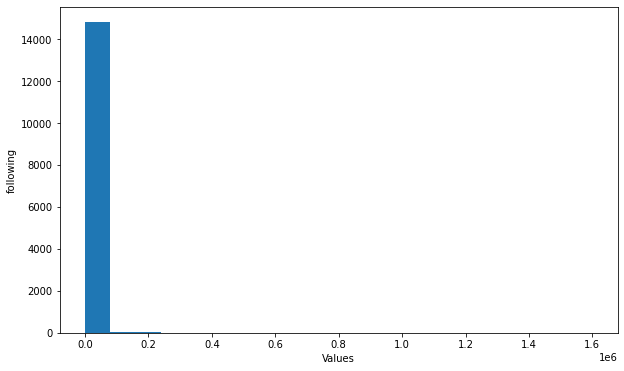

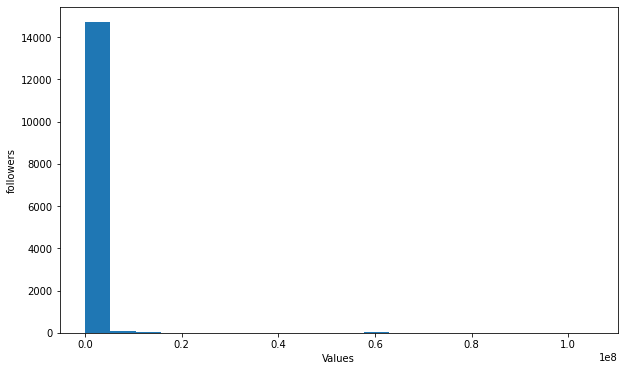

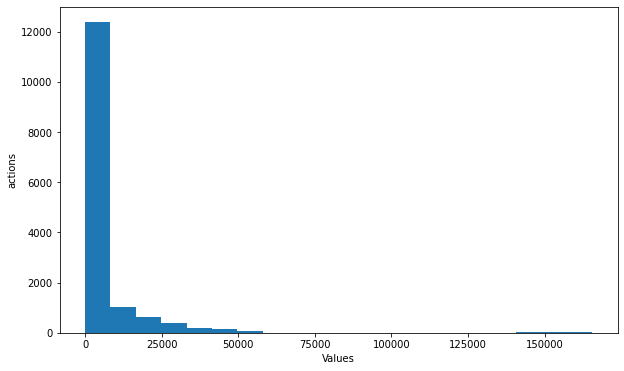

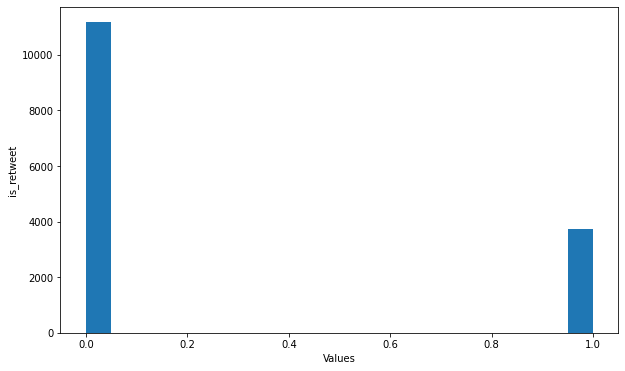

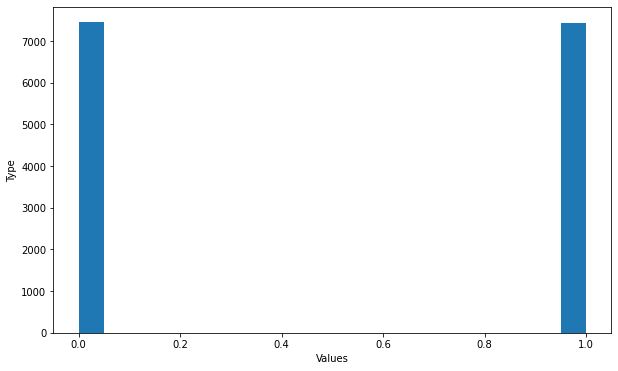

In [18]:
for column in data._get_numeric_data():
    analysis_hist(column)

Видим, что а) ни один из признаков не имеет нормального распределения б) для небинарных признаков самое частое значение - 0. Скорее всего, наиболее важную информацию несут сами твиты (мы намеренно не стали удалять ссылки и хештеги, потому что они, скорее всего, вообще сделают самый важный вклад). 

Географические локации было решено отбросить, потому что их сложно обработать качественно и есть серьезное подозрение, что они не дадут примерно никакого вклада

In [3]:
def feature_engineering(choice_transformer, choice_ngrams):
    
    """числовые характеристики нормализуем:
    imputer обрабатывает наны, scaler масштабирует"""
    
    numeric_features = ['following', 'followers', 'actions', 'is_retweet']
    numeric_transformer = Pipeline(
        steps=[("imputer", SimpleImputer(strategy="median")), ("scaler", StandardScaler())]
    )

    # текстовые характеристики обрабатываем: либо tf-idf, либо мешок слов
    text_features = 'Tweet'
    if choice_transformer == 'tfidf':
        text_transformer = TfidfVectorizer(ngram_range=choice_ngrams, tokenizer=word_tokenize, stop_words='english')
    else:
        text_transformer = CountVectorizer(ngram_range=choice_ngrams, tokenizer=word_tokenize, stop_words='english')

    preprocessor = ColumnTransformer(
        transformers=[
            ("num", numeric_transformer, numeric_features),
            ("txt", text_transformer, text_features),
        ]
    )
    return preprocessor

### Кластеризация

Поскольку у нас все оказалось слишком легко, мы решили запилить кластеризацию just for lulz

Сперва нарисовали PCA (из-за того, что матрица itfidf разреженная, пришлось взять TruncatedSVD) и t-SNE для исходных меток, чтобы посмотреть, насколько четенько они укладываются по кластерам (да! четенько)

In [21]:
def plot_draw(cluster_labels):
    """Функция для построения графика, принимает ярлыки кластеров"""
    plt.figure(figsize=(13,10))
    plt.scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_labels, s=20, cmap='viridis');
    plt.colorbar()
    plt.show()

In [39]:
def metrics_print(method):
    """Красивый вывод метрик"""
    print(method, '\n--------')
    print(f"{'Homogeneity':<30}{metrics.homogeneity_score(y, method.labels_):>6.3f}")
    print(f"{'Completeness':<30}{metrics.completeness_score(y, method.labels_):>6.3f}")
    print(f"{'V-measure':<30}{metrics.v_measure_score(y, method.labels_):>6.3f}")
    print(f"{'Adjusted Rand-Index':<30}{metrics.adjusted_rand_score(y, method.labels_):>6.3f}")
    print(f"{'Adjusted mutual info score':<30}{metrics.adjusted_mutual_info_score(y, method.labels_):>6.3f}")

In [23]:
X_processed = feature_engineering('tfidf', (1, 1)).fit_transform(X)

In [27]:
tsvd = TruncatedSVD()
X_pca = tsvd.fit_transform(X_processed)

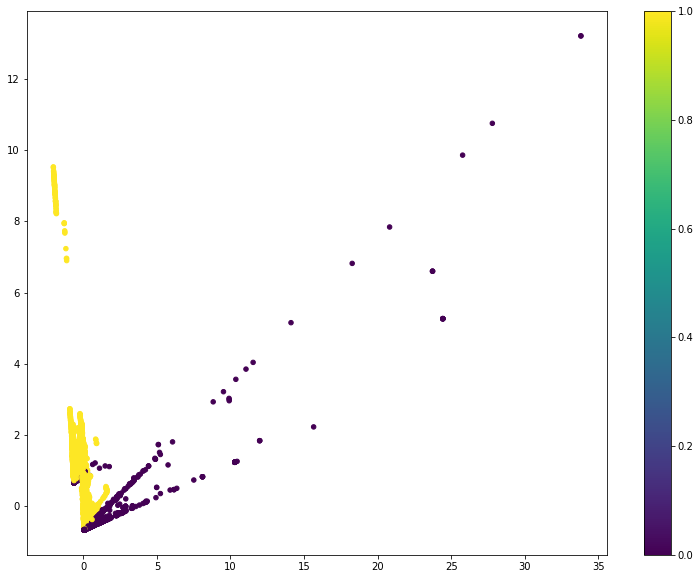

In [28]:
plot_draw(y)

Text(0.5, 1.0, 'MNIST. t-SNE projection')

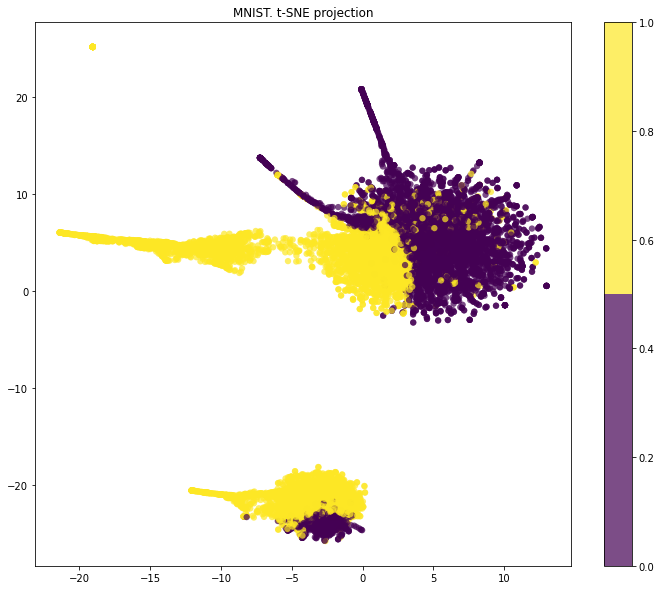

In [50]:
tsne = TSNE(random_state=17)
X_tsne = tsne.fit_transform(X_processed)

plt.figure(figsize=(12,10))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y, 
            edgecolor='none', alpha=0.7, s=40,
            cmap=plt.cm.get_cmap('viridis', 2))
plt.colorbar()
plt.title('MNIST. t-SNE projection')

Какая-то рыба-меч получилась... с детенышем

PCA, как ни странно, нагляднее. 

Дальше попробуем кластеризовать двумя вариантами (был еще DBSCAN, но не взлетел - не трактуемые кластеры, а как правильнее подобрать e, мы че-то не разобрались)

AgglomerativeClustering() 
--------
Homogeneity                    0.001
Completeness                   0.090
V-measure                      0.002
Adjusted Rand-Index            0.000
Adjusted mutual info score     0.002


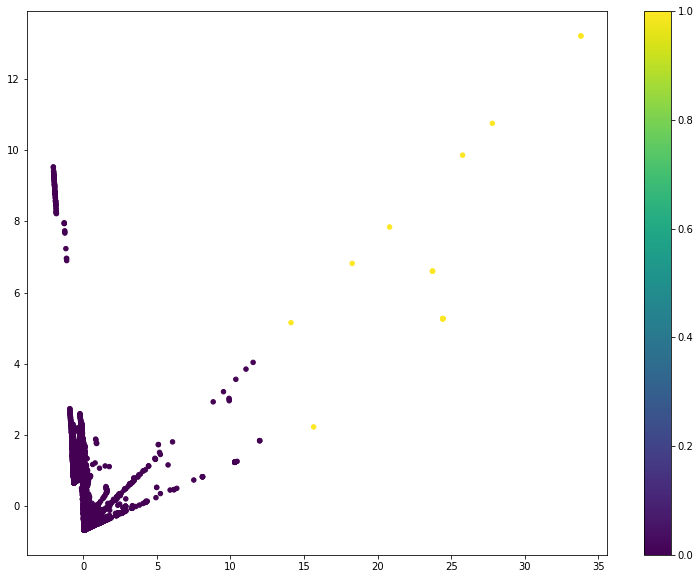

In [43]:
cluster = AgglomerativeClustering(n_clusters=2)
cluster.fit(X_pca)
metrics_print(cluster)
plot_draw(cluster.fit_predict(X_pca))

KMeans(n_clusters=2) 
--------
Homogeneity                    0.003
Completeness                   0.103
V-measure                      0.006
Adjusted Rand-Index            0.000
Adjusted mutual info score     0.006


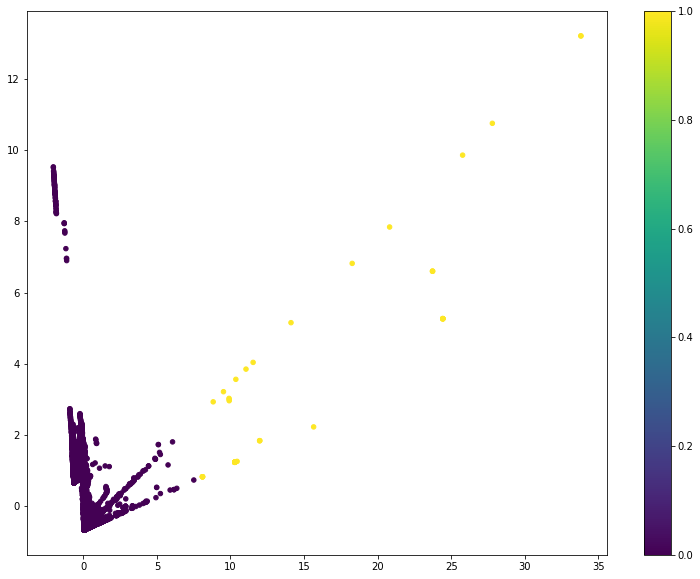

In [42]:
kmeans = KMeans(n_clusters=2).fit(X_pca)
metrics_print(kmeans)
plot_draw(kmeans.fit_predict(X_pca))

K-Means на текстах дал лучший результат (не намного, правда). Метрики очень плохие у всего. 

### Обучение моделей

In [14]:
test = pd.read_csv('test.csv')
test.drop('Id', axis=1, inplace=True)
test.head()

,Tweet,following,followers,actions,is_retweet,location
0,"Cops shoot blacks almost everyday, and there a...",5509.0,5977.0,8062.0,1,ですpacito
1,"#HAPPYTAEYANGDAY Oppa,happy birthday to you, ...",0.0,0.0,NaN,0,NaN
2,RT @HoneyBadger10: Panthers in the super bowl....,471.0,229.0,747.0,0,"B'klyn, NYC, LA"
3,Sorry my Twitter keeps posting my retweets a m...,0.0,79800.0,48.0,0,NaN
4,Heart attack causes and symptoms are different...,902.0,5797.0,4270.0,0,Chicago


In [4]:
def modelfit(model, filename):
    model.fit(Xtrain, ytrain)
    
    ypredtest = model.predict(Xtest)
    ypredtrain = model.predict(Xtrain)
    
    print(accuracy_score(ytest, ypredtest), accuracy_score(ytrain, ypredtrain))
    
    y_final_test = model.predict(test)
    df = pd.DataFrame(list(zip(range(len(y_final_test)), y_final_test)), columns=['Id', 'Type'])
    df['Type'] = df['Type'].apply(lambda x: 'Quality' if x == 0 else 'Spam')
    df.to_csv(f'submission_{filename}.csv', index=False)

In [10]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2)

TF-IDF unigrams

In [66]:
preprocessor = feature_engineering('tfidf', (1, 1))

clfLR = Pipeline(
    steps=[("preprocessor", preprocessor), ("classifier", LogisticRegression())]
)

clfSVC = Pipeline(
    steps=[("preprocessor", preprocessor), ("classifier", SVC())]
)

In [67]:
modelfit(clfLR, 'tfidfUniLogreg')
modelfit(clfSVC, 'tfidfUniSvc')

0.9671140939597316 0.9739867416296047
0.9704697986577181 0.9812872367206512


TF-IDF bigrams

In [68]:
preprocessor = feature_engineering('tfidf', (2, 2))

clfLR = Pipeline(
    steps=[("preprocessor", preprocessor), ("classifier", LogisticRegression())]
)

clfSVC = Pipeline(
    steps=[("preprocessor", preprocessor), ("classifier", SVC())]
)

In [69]:
modelfit(clfLR, 'tfidfBiLogreg')
modelfit(clfSVC, 'tfidfBiSvc')

0.9389261744966443 0.9661827641184862
0.9533557046979866 0.9749097927330704


BOW unigrams

In [70]:
preprocessor = feature_engineering('bow', (1, 1))

clfLR = Pipeline(
    steps=[("preprocessor", preprocessor), ("classifier", LogisticRegression())]
)

clfSVC = Pipeline(
    steps=[("preprocessor", preprocessor), ("classifier", SVC())]
)

In [71]:
modelfit(clfLR, 'bowUniLogreg')
modelfit(clfSVC, 'bowUniSvc')

f:\code\python\python38\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.9604026845637584 0.9913568851220945
0.9570469798657718 0.9833011664009398


BOW bigrams

In [72]:
preprocessor = feature_engineering('bow', (2, 2))

clfLR = Pipeline(
    steps=[("preprocessor", preprocessor), ("classifier", LogisticRegression())]
)

clfSVC = Pipeline(
    steps=[("preprocessor", preprocessor), ("classifier", SVC())]
)

In [73]:
modelfit(clfLR, 'bowBiLogreg')
modelfit(clfSVC, 'bowBiSvc')

0.9540268456375839 0.9945456071158849
0.95 0.984895527397835


BOW Bagging

In [77]:
preprocessor = feature_engineering('bow', (1, 1))

bagging = Pipeline(
    steps=[("preprocessor", preprocessor), ("classifier", BaggingClassifier())]
)

In [78]:
modelfit(bagging, 'bowUniBag')

0.9946308724832215 0.999160862633213


In [79]:
preprocessor = feature_engineering('bow', (2, 2))

bagging = Pipeline(
    steps=[("preprocessor", preprocessor), ("classifier", BaggingClassifier())]
)

In [80]:
modelfit(bagging, 'bowBiBag')

0.9969798657718121 0.9987412939498196


Random Forest

In [15]:
preprocessor = feature_engineering('bow', (2, 2))

clf = Pipeline(
    steps=[("preprocessor", preprocessor), ("classifier", RandomForestClassifier())]
)

modelfit(clf, 'bowBiForest')

0.9939597315436242 1.0


Проверка только на твитах (чтобы посмотреть, что влияет сильнее всего)

In [18]:
vec = CountVectorizer(ngram_range=(3, 3), tokenizer=word_tokenize, stop_words='english')
bow = vec.fit_transform(Xtrain['Tweet'])
clf = DecisionTreeClassifier()
clf.fit(bow, ytrain)
ypredtest = clf.predict(vec.transform(Xtest['Tweet']))
print(classification_report(ypredtest, ytest))

              precision    recall  f1-score   support

           0       0.96      0.59      0.73      2387
           1       0.35      0.89      0.50       593

    accuracy                           0.65      2980
   macro avg       0.65      0.74      0.62      2980
weighted avg       0.83      0.65      0.68      2980



In [19]:
list(vec.vocabulary_.items())[:10]

[('just need :', 66165),
 ('need : return', 76390),
 (': return neoliberalizer-in-chief', 23662),
 ('return neoliberalizer-in-chief !', 86588),
 ('neoliberalizer-in-chief ! ,', 76626),
 ('! , #', 389),
 (', # weneedberniehttp', 9251),
 ('# weneedberniehttp :', 4823),
 ('weneedberniehttp : //abcnews.go.com/politics/bill-clinton-charge-revitalizing-economy-hillary-clinton/story',
  103931),
 (': //abcnews.go.com/politics/bill-clinton-charge-revitalizing-economy-hillary-clinton/story ?',
  19401)]

Проверим гипотезу о том, что ссылки сильнее всего влияют на определение спама

In [21]:
tweets = list(data['Tweet'])
nums = []

for num, w in enumerate(tweets):
    if 't.co' in w:
        nums.append(num)

In [22]:
spamham = list(data['Type'])
needed = []
for i, w in enumerate(spamham):
    if i in nums:
        needed.append(w)

In [23]:
from collections import Counter

Counter(needed)

Counter({1: 4551, 0: 67})

Оказывается, подавляющее большинство текстов со ссылками определено как спам